[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb)

# Assignment 2 execution

In [1]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader

2023-02-22 18:22:19.481318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 18:22:20.295194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/pkgs/cudatoolkit-11.2.2-hbe64b41_10/lib/libcudart.so.11.0
2023-02-22 18:22:20.295338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/pkgs/cudatoolkit-11.2.2-hbe64b41_10/lib/libcuda

In [3]:
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
# Fix the random state to 42
DATA_SPLITTING_RANDOM_SEED = 42
fix_seed(DATA_SPLITTING_RANDOM_SEED)

## Data loading

### Dataset download

In [5]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [6]:
data_folder = 'Dataset'

In [7]:
# Train & Validation data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [8]:
def load_coqa_dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data_arr = json.load(file_obj)["data"]
    print(f'{len(data_arr)} stories / {len(data_arr[0]["questions"])} questions in the first row')
    
    # Prepare the Categorical DTypes

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in data_arr]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in data_arr]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")
    
    # Transform into a numpy matrix (denormalization and categorical factorization)

    data_arr = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
            #story["questions"][question_index]["turn_id"],
        ]
        for story in data_arr
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{data_arr.shape} question-answer pairs x columns')
    print(f'First row: {data_arr[0]}')
    
    # Transform into a DataFrame
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    return pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(data_arr[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(data_arr[:,1].astype(np.int16), dtype=storyDType)),
        "q": data_arr[:,2],
        "a": data_arr[:,3],
        "span": data_arr[:,4],
    })

In [9]:
def append_shifted_question_to_coqa_dataset(df:pd.DataFrame, shift:int) -> (pd.DataFrame,int):
    if shift <= 0:
        raise Exception("shift must be greater than zero")
    history_mask = df["p"] == df["p"].shift(shift)
    history_series = df["history"].astype(str) + ' ' + df["q"].shift(shift) + ' ' + df["a"].shift(shift) + '.'
    df["history"] = np.where(history_mask, history_series, df["history"])
    return df, history_mask.sum()

In [10]:
def transform_coqa_dataset_with_history(df:pd.DataFrame, max_history_depth:int) -> pd.DataFrame:
    df["history"] = ""
    for i in range(1, max_history_depth+1):
        df, count = append_shifted_question_to_coqa_dataset(df, i)
        #print(i, count)
        if(count == 0):
            break;
    return df

In [11]:
train_df = transform_coqa_dataset_with_history(load_coqa_dataset("train.json"), 3)
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source     107276
p          107276
q          107276
a          107276
span       107276
history    107276
dtype: int64

In [12]:
pd.unique(train_df["p"]).size

6605

In [13]:
pd.unique(train_df["span"]).size

99470

In [14]:
pd.unique(train_df["source"]).size

5

In [15]:
train_df.head()

,source,p,q,a,span,history
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475,
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library,When was the Vat formally opened? It was form...
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...,what is the library for? research. When was t...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...,"for what subjects? history, and law. what is ..."
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi...","and? philosophy, science and theology. for wh..."


In [16]:
train_df.memory_usage(deep=True)

Index           128
source       107764
p          14241201
q           9110271
a           7714559
span       12090637
history    18873223
dtype: int64

In [17]:
test_df = transform_coqa_dataset_with_history(load_coqa_dataset("test.json"), 3)
test_df.count()

500 stories / 12 questions in the first row
499 distinct stories
5 distinct sources: Index(['mctest', 'race', 'cnn', 'wikipedia', 'gutenberg'], dtype='object')
(7917, 5) question-answer pairs x columns
First row: ['0' '0' 'What color was Cotton?' 'white'
 'a little white kitten named Cotton']


source     7917
p          7917
q          7917
a          7917
span       7917
history    7917
dtype: int64

## Exploratory Data Analysis

In [18]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [19]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [20]:
train_df["a"][42]

'Yes'

In [21]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [22]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

Sources:

<AxesSubplot:>

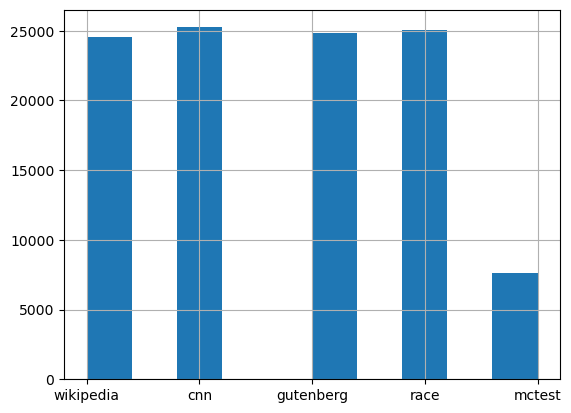

In [23]:
train_df["source"].hist()

Occurrences of 25 most popular stories:

<AxesSubplot:>

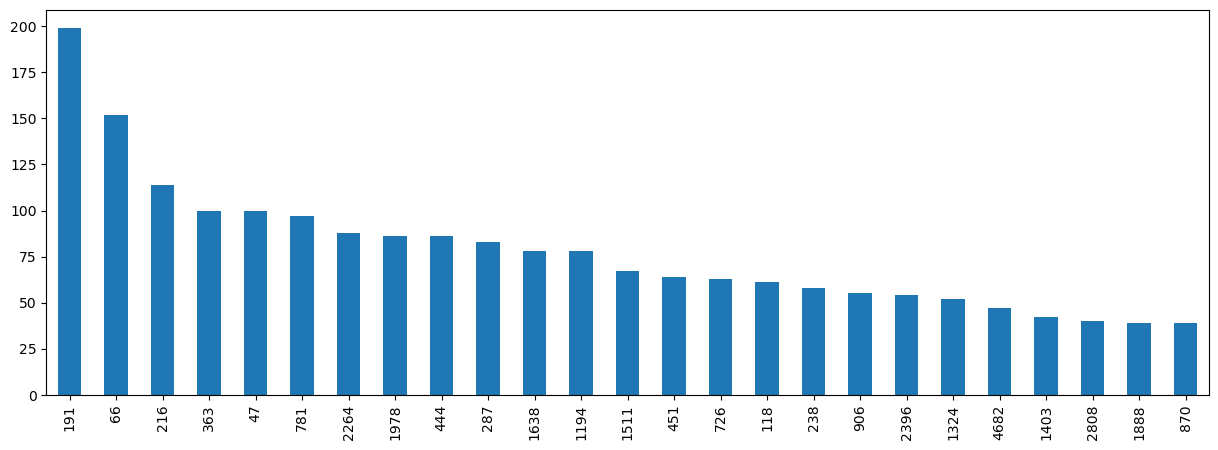

In [24]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

Occurrences of 25 least popular stories:

<AxesSubplot:>

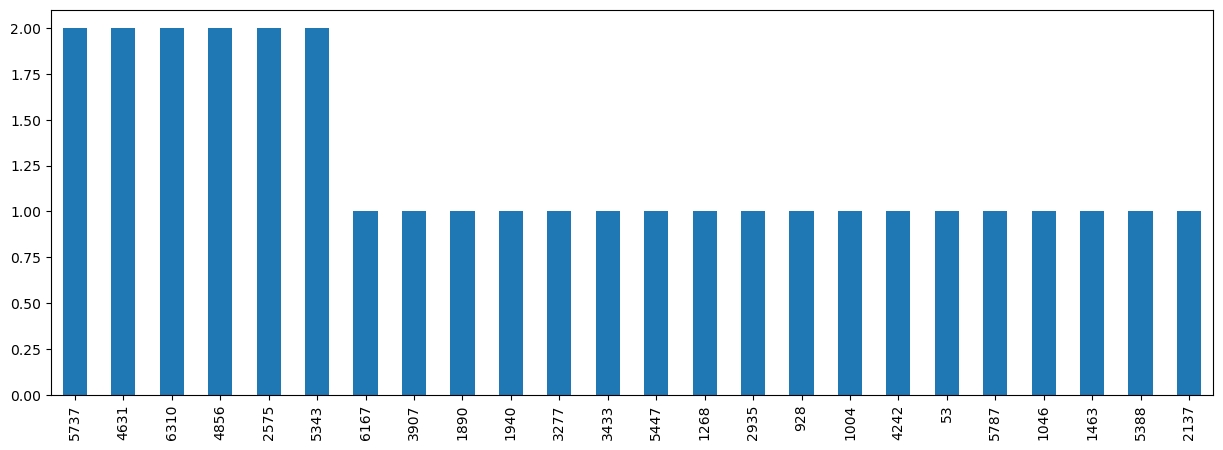

In [25]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

Histogram of story popularities:

<AxesSubplot:>

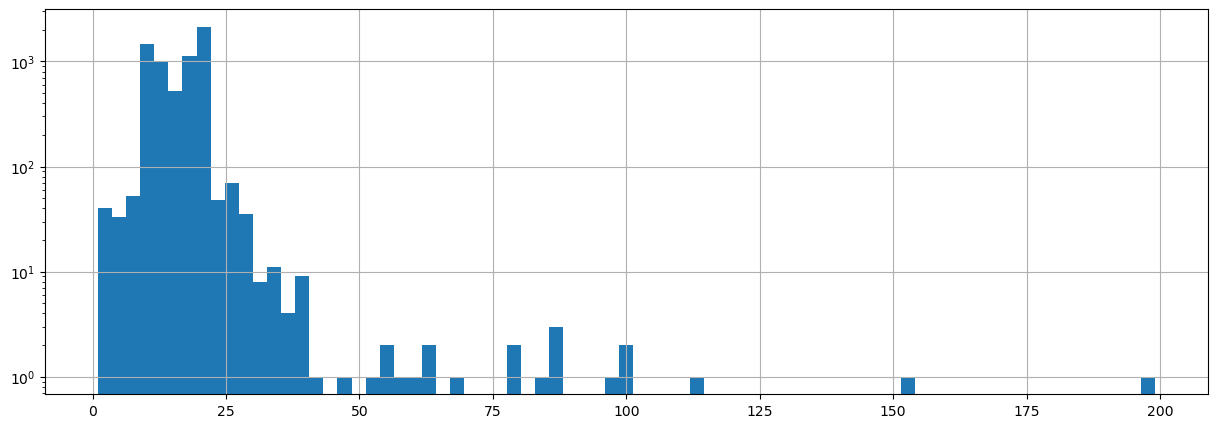

In [26]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [27]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

### Removing rows with outlier story/question/answer/span lengths to save memory

In [28]:
train_df.count()

source     107276
p          107276
q          107276
a          107276
span       107276
history    107276
dtype: int64

In [29]:
REMOVE_OUTLIERS = False
def remove_outliers(train_df:pd.DataFrame)->pd.DataFrame:
    #remove stories
    story_lengths = train_df["p"].str.len()
    #logarithmic histogram
    #story_lengths.hist(log=True,bins=75,figsize=(15,5))
    p_length_limit = story_lengths.quantile(0.999)
    p_length_mask = story_lengths < p_length_limit
    train_df = train_df[p_length_mask]
   
    #remove questions,answers, spans
    question_lengths = train_df["q"].str.len()
    #question_lengths.hist(log=True,bins=75,figsize=(15,5))
    q_length_limit = question_lengths.quantile(0.999)
    answer_lengths = train_df["a"].str.len()
    #answer_lengths.hist(log=True,bins=75,figsize=(15,5))
    a_length_limit = answer_lengths.quantile(0.999)
    span_lengths = train_df["span"].str.len()
    #span_lengths.hist(log=True,bins=75,figsize=(15,5))
    span_length_limit = span_lengths.quantile(0.999)
    
    bad_length_mask = (question_lengths > q_length_limit) | (answer_lengths > a_length_limit) | (span_lengths > span_length_limit)
    excluded_stories = train_df["p"][bad_length_mask].unique()
    excluded_mask = ~train_df["p"].isin(excluded_stories)
    train_df = train_df[excluded_mask]
    return train_df

In [30]:
if REMOVE_OUTLIERS:
    train_df = remove_outliers(train_df)
train_df.count() 

source     107276
p          107276
q          107276
a          107276
span       107276
history    107276
dtype: int64

### Preprocessing

The function below transforms all the text in the dataframe into lower case.

In [31]:
def preprocess(df:pd.DataFrame) -> pd.DataFrame:
  df = df.applymap(lambda s: s.lower() if type(s) == str else s)
  return df

## Train-Validation(-Test) split

In [32]:
train_df = train_df.reset_index(drop=True)
total_rows = len(train_df)
ideal_split_index = int(total_rows * 0.2)

In [33]:
ENABLE_DATASET_SHUFFLING = True
def train_val_split(df:pd.DataFrame)->Tuple[pd.DataFrame, pd.DataFrame]:
  if ENABLE_DATASET_SHUFFLING:
    all_stories = df["p"].drop_duplicates()
    val_stories = all_stories.sample(frac=0.2, random_state=DATA_SPLITTING_RANDOM_SEED) # random sample
    val_mask = df["p"].isin(val_stories)
    val_question_count = val_mask.sum()
    train_question_count = (~val_mask).sum()
    val_story_count = val_stories.count()
    train_story_count = all_stories.count() - val_story_count
    print(f"""
        Splitting validation dataset from train dataset with random sampling
        Stories: {train_story_count} vs {val_story_count}
        Questions: {train_question_count} vs {val_question_count} (ideal split: {ideal_split_index})
    """)
    #val_df = df[val_mask].sample(frac=1, random_state=DATA_SPLITTING_RANDOM_SEED) # Selection + Random shuffling
    #train_df = df[~val_mask].sample(frac=1, random_state=DATA_SPLITTING_RANDOM_SEED) # Selection + Random shuffling
    val_df = df[val_mask] # Selection 
    train_df = df[~val_mask] # Selection
  else:
    print("Splitting validation dataset from train dataset without random sampling")
    before_split_mask = pd.Series(np.linspace(0, total_rows, total_rows)) < ideal_split_index
    split_story_mask = df["p"] == df["p"][ideal_split_index - 1]
    val_mask = before_split_mask | split_story_mask
    val_df = df[val_mask]
    train_df = df[~val_mask]
  return train_df, val_df

In [34]:
train_df, val_df = train_val_split(train_df)


        Splitting validation dataset from train dataset with random sampling
        Stories: 5284 vs 1321
        Questions: 85826 vs 21450 (ideal split: 21455)
    


In [35]:
ALTERNATIVE_SPLIT = False
if ALTERNATIVE_SPLIT:
  from sklearn.model_selection import train_test_split
  stories = list(train_df['p'].unique())
  print(f'Total n° of stories: {len(stories)}')
  train_stories, val_stories = train_test_split(stories, test_size=0.2, random_state=42)
  val_df = train_df[train_df['p'].isin(val_stories)]
  train_df = train_df[train_df['p'].isin(train_stories)]
  len(train_stories), len(val_stories)

In [36]:
#reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [37]:
print(f'Training set shape: {train_df.shape}\nValidation set shape: {val_df.shape}\nTest set shape: {test_df.shape}')

Training set shape: (85826, 6)
Validation set shape: (21450, 6)
Test set shape: (7917, 6)


In [38]:
#convert to lower case
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

## Utilities

In [39]:
def free_some_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_accumulated_memory_stats()
    gc.collect()

#### Save and load results

In [40]:
import json

results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

def results_to_json(test_df, 
                    generated_df, 
                    model_name,
                    seed,
                    history):
    '''
    Given the test dataframe, the dataframe resulting from generated_answers, and the name of the model, writes on a file (JSON format) the concatenation of the two DataFrames.

    Args:
        test_df: DataFrame already given as input for generation purposes
        generated_df: Output DataFrame of the method generate_answers()
        model_name: name of the model, it will define the path for the JSON file
        seed: the used seed
        history: history flag
    '''
    
    # drop answers column to avoid duplicate columns
    df_g = generated_df.copy().drop(columns=["answers"])
    
    final = pd.concat([test_df.copy(), df_g.copy()], axis=1)
    h_flag = ""
    if history == True:
        h_flag = "_history"
    if model_name == 'prajjwal1/bert-tiny':
        model_name = "bert-tiny"
    json_path = f"{results_folder}/{model_name}_{seed}{h_flag}.json"
    final.to_json(path_or_buf=json_path)
    csv_path = f"{results_folder}/{model_name}_{seed}{h_flag}.csv"
    final.to_csv(path_or_buf=csv_path, columns=["q","a","generated","score","history","span"])

In [41]:
def results_from_json(model_name,
                    seed,
                    history):
    '''
    Given the name of a model, returns the DataFrame loaded by a JSON file, containing the results previously savd on disk of the generate_answers() method.
    
    Args:
        model_Name: name of the model for which return the results
        seed: the wanted seed
        history: history flag
    '''
    h_flag = ""
    if history == True:
        h_flag = "_history" 
    if model_name == 'prajjwal1/bert-tiny':
        model_name = "bert-tiny"
    path = f"results/{model_name}_{seed}{h_flag}.json"
    # Opening JSON file
    with open(path) as f:

        # returns JSON object as a dictionary
        data = json.load(f)

        # Use pandas.DataFrame.from_dict() to Convert JSON to DataFrame
        df_results = pd.DataFrame.from_dict(data, orient="columns")

        return df_results

#### Pytorch Dataset

In [42]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

### Metric

Instead of importing the whole allennlp library, we decided to copy from the source code only of the functions necessary for our task.

In [43]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

## Model definition

The task of this assignment is to generate an answer, given a question and a context, so we can consider this as a sequence to sequence task. 
To tackle the sequence to sequence task, or Question-Answering task, we decided to use transformer-based encoder-decoder models - often also called seq2seq transformer models. The EncoderDecoderModel is initialized from a pretrained encoder checkpoint and a pretrained decoder checkpoint. To do so, the EncoderDecoderModel class provides a EncoderDecoderModel.from_encoder_decoder_pretrained() method.

In [44]:
BERT_TINY = 'prajjwal1/bert-tiny'
DISTIL_ROBERTA = 'distilroberta-base'
def getModel(model_name):
  if(model_name != BERT_TINY) and (model_name != DISTIL_ROBERTA):
    raise Exception("ValueError: model name should be 'prajjwal1/bert-tiny' or 'distilroberta-base'.")
  
  # tie_encoder_decoder to share weights and half the number of parameters
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name,
                                                                          tie_encoder_decoder=True)
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # set special tokens
  model.config.decoder_start_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id

  # set decoding parameters                             
  model.config.early_stopping = True
  model.config.no_repeat_ngram_size = 3
  model.config.repetition_penalty = 5.0
  model.config.num_beams = 2
  model.config.vocab_size = model.config.encoder.vocab_size
  return model, tokenizer


### Train Functionalities


In [45]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          epoch: int) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
    """    
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step() 
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            loss, outputs = model(input_ids,
                                  attention_mask=attention_mask,
                                  labels = labels
                            )[:2]
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [46]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim, 
                  model: torch.nn.Module, 
                  loader_train: torch.utils.data.DataLoader, 
                  loader_val: torch.utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device, 
                                           optimizer, epoch)
        loss_val = validate(model, loader_val, device)
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

### Encodings


Before passing the input data to the model, we need to tokenize the data so that it is readable by the model. The encoding is done by using a pretrained tokenizer, which encodes both our question and context strings into single arrays of tokens, and the answer strings separately. If the history flag is on, then the dialogue history is appended to the question strings.

In [47]:
def tokenize_coqa_questions(df:pd.DataFrame,
                            history:bool, 
                            tokenizer:PreTrainedTokenizer,
                            max_length:int) -> BatchEncoding:
    if history:
        #concatenating the question with the history 
        print(f'encoding WITH history')
        questions = df["q"].str.cat(df["history"]) # If needed a separator can be passed, for example with sep='[SEP] '
        #questions = df_input[["q", "history"]].apply(" ".join, axis=1) # Equivalent
    else:
        print(f'encoding without history')
        questions = df['q']

    return tokenizer(
        list(questions),
        list(df['p']),  
        padding=True,
        truncation= 'only_second', 
        max_length = encoder_max_length,
    )

In [48]:
BERT_TINY_ENCODER_MAX_LENGTH = 499
DISTILLROBERTA_ENCODER_MAX_LENGTH = 512
def encodings(model_name:str, 
              tokenizer:PreTrainedTokenizer,
              df:pd.DataFrame,
              history:bool) -> BatchEncoding:
  if(model_name == BERT_TINY):
    encoder_max_length = BERT_TINY_ENCODER_MAX_LENGTH
    decoder_max_length = 64
  elif(model_name == DISTIL_ROBERTA):
    encoder_max_length = DISTILLROBERTA_ENCODER_MAX_LENGTH
    decoder_max_length = 64

  encodings = tokenize_coqa_questions(df, history, tokenizer, encoder_max_length)
  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']

  label_values = tokenizer(list(df['a']),
                            padding=True,
                            truncation=True,
                            max_length = decoder_max_length,
                            )
  labels, labels_mask = label_values['input_ids'], label_values['attention_mask']
  #Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
  masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]

  #print(f"""
   # Question 42 decoded: {tokenizer.decode(input_ids[42])}
   # Answer 42 decoded: {tokenizer.decode(labels[42])}
  #""")

  #add the labels to the batch encodings dictionary, then this will be used to create a pytorch dataset
  if(model_name == BERT_TINY):
    #token_type_ids are not relevant for the training process
    encodings.pop('token_type_ids')
  encodings.update({'labels': masked_labels})
  return encodings

### Generation

The decoding process consists in generating a sequence of words, in this case is the answer. This process relies on a decoding strategy, which define how the model choose what words it should output once it knows the probabilities. There exist different decoding strategies, some of which are greedy search, top-k sampling, and beam search.
The generation of answer is done by using a beam search strategy, instead of a greedy approach. 

In [49]:
def generate_answers(model: torch.nn.Module,
                    tokenizer: PreTrainedTokenizer,
                    df_input: pd.DataFrame,
                    max_length: int,
                    history: bool = False,
                     ) -> pd.DataFrame:

    '''
    Given the model and the input, returns a dataframe cointaining the generated answers and relative F1-score
    
    Args:
        model: Torch model used to generate answers
        tokenizer: generic tokenizer
        df_input: dataframe containing the input to the model
        max_length: max length applied in the tokenization
        history: history flag.
    '''

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    input_values = tokenize_coqa_questions(df_input, history, tokenizer, max_length)
    input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']
    list_generated = []
    model.to(device)
    # Set the model in evaluation mode
    model.eval()
    for input, mask in zip(input_ids,input_attention_mask):
        input = np.expand_dims(np.array(input), axis=0)
        mask = np.expand_dims(np.array(mask), axis=0)
        generated = model.generate(input_ids=torch.tensor(input).to(device),
                                                        max_length=20,
                                                        repetition_penalty=5.,
                                                        min_length=1,
                                                        no_repeat_ngram_size=3,
                                                        early_stopping=True,
                                                        decoder_start_token_id = model.config.decoder_start_token_id,
                                                        num_beams=2,
                                                        )
        generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
        list_generated.append(generated)

    # Create a dataframe and insert the real answers
    df_generated = pd.DataFrame(list_generated, columns = ['generated'])
    df_generated['answers'] = df_input['a']

    # Generate and insert the F1-score
    score = []
    for a_pred, a_gold in zip(df_generated['generated'], df_generated['answers']):
        score.append(compute_f1(a_pred, a_gold))
    df_generated['score'] = score

    # Print average f1_score and the answers with score greater than 0
    average_score = np.mean(score)*100
    predicted = len(df_generated[df_generated['score'] != 0])
    
    print(f'Average_score: {average_score}')
    print(f'N° of samples with score greater than zero: {predicted} / {len(df_generated)}')
    return df_generated

### Execution

In [50]:
def execute(model_name: str,
            lr: float, 
            num_epochs: int, 
            batch_size: int,
            train_df: pd.DataFrame,
            val_df: pd.DataFrame,
            history:bool=False,
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the 
        tokenizer, and then executes the training loop.

    Args:
        model: the network to train.
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        train_df: training dataframe.
        val_df: validation dataframe.
        history: questions-answers history flag.
    """
    #get the model and the tokenizer
    model, tokenizer = getModel(model_name)
    #Start encodings
    print(f'STARTING ENCODING:')
    print(f'Train set:')
    train_encodings = encodings(model_name, tokenizer, train_df, history)
    print(f'Validation set:')
    val_encodings = encodings(model_name, tokenizer, val_df, history)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )
    #create validation dataset
    val_dataset = CreateDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle = False
                                        )

    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    print(f'STARTING TRAINING:')
    statistics = training_loop(num_epochs, optimizer, model,
                               data_loader_train, data_loader_val)
    print(f'TRAINING COMPLETE.')
    return model, tokenizer


## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

### Define model 

In [50]:
# Select seed 42,2022,1337
TRAINING_RANDOM_SEED = 2022

# Select model
#model_name = BERT_TINY
model_name = DISTIL_ROBERTA

# History flag
history = True
#history = False

### Training

In [ ]:
fix_seed(TRAINING_RANDOM_SEED)

#parameters 
if(model_name == BERT_TINY):
    lr = 4e-4
    encoder_max_length = BERT_TINY_ENCODER_MAX_LENGTH
elif(model_name == DISTIL_ROBERTA):
    lr = 4e-5
    encoder_max_length = DISTILLROBERTA_ENCODER_MAX_LENGTH

num_epochs = 3

#if you are having runtime error reduce the batch size to 12 or 8
batch_size = 16

#execute
model, tokenizer = execute(model_name, lr, num_epochs, batch_size, train_df, val_df, history=history)

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

STARTING ENCODING:
encoding WITH history
encoding WITH history
ENCODING COMPLETE.
STARTING TRAINING:


  0%|          | 0/5142 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Epoch 1: 100%|██████████| 5142/5142 [03:50<00:00, 22.33it/s, loss=4.36]


Epoch: 1  Lr: 0.00040000  Loss: Train = [3.9323] - Val = [3.5859]  Time one epoch (s): 245.2318 


Epoch 2: 100%|██████████| 5142/5142 [03:48<00:00, 22.47it/s, loss=2.31]


Epoch: 2  Lr: 0.00040000  Loss: Train = [3.3018] - Val = [3.5410]  Time one epoch (s): 243.9631 


Epoch 3: 100%|██████████| 5142/5142 [03:48<00:00, 22.53it/s, loss=2.06]


Epoch: 3  Lr: 0.00040000  Loss: Train = [3.0181] - Val = [3.5642]  Time one epoch (s): 243.3879 
Time for 3 epochs (s): 732.584
TRAINING COMPLETE.


In [ ]:
free_some_memory()

### Evaluation

####Evaluation on validation set

Encode the validation set using the tokenizer defined before.

In [ ]:
print(f'STARTING GENERATION on validation set:')
df_generated = generate_answers(model = model, 
                                tokenizer = tokenizer,
                                df_input = val_df,
                                max_length = encoder_max_length,
                                history = history)
print(f'GENERATION COMPLETE.')

STARTING GENERATION on validation set:
encoding WITH history
Average_score: 16.186003373198457
N° of samples with score greater than 0: 4383 / 20539
GENERATION COMPLETE.


In [ ]:
# save
results_to_json(val_df, df_generated, model_name, TRAINING_RANDOM_SEED, history)
# load
# df_results = results_from_json(model_name, TRAINING_RANDOM_SEED, history)

In [ ]:
!zip -r val_results.zip results

  adding: results/ (stored 0%)
  adding: results/bert-tiny_1337_history.json (deflated 93%)
  adding: results/bert-tiny_1337_history.csv (deflated 79%)


####Evaluation on test set

Encode test set using the tokenizer defined before.

In [ ]:
print(f'STARTING GENERATION on test set:')
df_generated = generate_answers(model = model, 
                                tokenizer = tokenizer,
                                df_input = test_df,
                                max_length = encoder_max_length,
                                history = history)
print(f'GENERATION COMPLETE.')

STARTING GENERATION on test set:
encoding WITH history
Average_score: 16.785367494332917
N° of samples with score greater than 0: 1716 / 7917
GENERATION COMPLETE.


Save the contents of df_generated (concatenated with test_df) in the folder "results", as a JSON file.

In [ ]:
# save
results_to_json(test_df, df_generated, model_name, TRAINING_RANDOM_SEED, history)
# load
# df_results = results_from_json(model_name, TRAINING_RANDOM_SEED, history)

In [ ]:
!zip -r test_results.zip results

  adding: results/ (stored 0%)
  adding: results/bert-tiny_1337_history.json (deflated 92%)
  adding: results/bert-tiny_1337_history.csv (deflated 79%)


In [ ]:
pd.set_option('display.max_rows', None)
#correct_answers = df_generated[df_generated['score'] != 0].reset_index(drop=True).sort_values('score',ascending=False)
correct_answers = df_generated[df_generated['score'] != 0].reset_index(drop=True)
correct_answers.head(50)

,generated,answers,score
0,white,white,1.000000
1,in the barn,in a barn,1.000000
2,yes,Yes,1.000000
3,yes,Yes,1.000000
4,yes,yes,1.000000
5,yes,Yes,1.000000
6,yes,Yes,1.000000
7,yes,Yes,1.000000
8,meat soup,"hot soup and a container with rice, vegetables...",0.200000
9,yes,Yes,1.000000


## Conclusions

In this section we compute the error analysis task for every model(so the combination model_name-seed-history), but considering only the seed for which it has the worst SQUAD F1-score on test set. So we will consider the following four models:
- bert-tiny, no history, 1337, 17.013
- bert-tiny, history, 1337, 16.160
- distil-roberta, no history, 42, 50.074
- distil-roberta, history, 1337, 57.102  
For each of these models, we will report the worst 5 model errors for each source.

#### Printing the 5 worst errors for each model

In [51]:
selected_models = [ {
                        'model_name': BERT_TINY,
                        'seed': 1337,
                        'history': False
                    },
                    {
                        'model_name': BERT_TINY,
                        'seed': 1337,
                        'history': True
                    },
                    {
                        'model_name': DISTIL_ROBERTA,
                        'seed': 42,
                        'history': False
                    },
                    {
                        'model_name': DISTIL_ROBERTA,
                        'seed': 1337,
                        'history': True
                    }]

In [52]:
def get_worst_errors(df: pd.DataFrame, model_name: str, num_errors: int):
    '''
    Given a dataframe loaded with the results_from_json() method, returns a filtered and ordered dataframe of the 5 worst errors for each source, for the given model
        
    Args:
        df: DataFrame generated by predictions of a model
        model_name: name of the model tested. Models can have different ENCODER_MAX_LENGTH
        num_errors: number of errors to return
    '''
    
    sources = df['source'].unique()
    errors = pd.DataFrame(columns=df.columns)

    for source in sources:
        errors_source = df[df['source'] == source].sort_values(by='score', ascending=True)
        errors = pd.concat([errors, errors_source[:5]], axis=0)

    return errors

In [53]:
from IPython.display import display, HTML

n_errors_each_source = 5

for model in selected_models:
    print(model)
    df_res = results_from_json(**(model))
    df_errors = get_worst_errors(df_res, model, n_errors_each_source)
    display(df_errors.head(25))

{'model_name': 'prajjwal1/bert-tiny', 'seed': 1337, 'history': False}


,source,p,q,a,span,history,generated,score
0,mctest,"once upon a time, in a barn near a farm house,...",what color was cotton?,white,a little white kitten named cotton,,pink,0.0
4923,mctest,scott alan woke up very early that morning in ...,where did it take him?,down stream,down stream,what happened to the animal all of a sudden? ...,in the door,0.0
4922,mctest,scott alan woke up very early that morning in ...,what happened to the animal all of a sudden?,it fell in the water,fell in the water,did scott get off his bike? yes. what did the...,a dog,0.0
4920,mctest,scott alan woke up very early that morning in ...,what did the animal start doing?,barking,barking,what was it near? the river. where at? by the...,chewing,0.0
4919,mctest,scott alan woke up very early that morning in ...,what was it near?,the river,the river,where at? by the park. what did scott want to...,a dog,0.0
21,race,"my doorbell rings. on the step, i find the eld...",who is at the door?,an elderly chinese lady and a little boy,"on the step, i find the elderly chinese lady, ...",,her mother,0.0
5647,race,a new study suggests that early exposure to ge...,and what else?,let kids play in a reasonable amount of dirt,let your kids play in a reasonable amount of dirt,"what should we do? wash your hands , but don'...",the animal,0.0
5646,race,a new study suggests that early exposure to ge...,what should we do?,"wash your hands , but don't do it with antibac...","wash your hands , but don't do it with antibac...","who says? rob dunn. so, should we stop washin...",get a group of animals,0.0
5645,race,a new study suggests that early exposure to ge...,who says?,rob dunn,rob dunn,"so, should we stop washing our kids? no. what...",william bush,0.0
5644,race,a new study suggests that early exposure to ge...,"so, should we stop washing our kids?",no,does not mean people should stop washing,what caused inflammation in the lungs? killer...,yes,0.0


{'model_name': 'prajjwal1/bert-tiny', 'seed': 1337, 'history': True}


,source,p,q,a,span,history,generated,score
0,mctest,"once upon a time, in a barn near a farm house,...",what color was cotton?,white,a little white kitten named cotton,,pink,0.0
4915,mctest,scott alan woke up very early that morning in ...,how long had they known each other?,as long as he could remember,as long as could remember,what color was he? brown. what was the dog's ...,two years,0.0
4914,mctest,scott alan woke up very early that morning in ...,what color was he?,brown,brown,what was the dog's name? boscoe. what was it ...,pink,0.0
4913,mctest,scott alan woke up very early that morning in ...,what was the dog's name?,boscoe,boscoe,what was it doing? licking. what was touching...,a dog,0.0
4912,mctest,scott alan woke up very early that morning in ...,what was it doing?,licking,licked,what was touching him that made him awake? a ...,sitting,0.0
21,race,"my doorbell rings. on the step, i find the eld...",who is at the door?,an elderly chinese lady and a little boy,"on the step, i find the elderly chinese lady, ...",,her mother,0.0
5730,race,george washington carver showed that plant lif...,what was carver's full name?,george washington carver,george washington carver,what is chemurgy called today? the science of...,allen,0.0
5729,race,george washington carver showed that plant lif...,what is chemurgy called today?,the science of synthetics,oday the science of chemurgy is better known a...,where do these raw materials originate from? ...,""" the united states """,0.0
5728,race,george washington carver showed that plant lif...,where do these raw materials originate from?,farm products,the branch of chemistry that studies and finds...,what branch of chemistry seeks ways to use ra...,in the united states,0.0
5727,race,george washington carver showed that plant lif...,what branch of chemistry seeks ways to use raw...,chemurgy.,the branch of chemistry that studies and finds...,,engineers,0.0


{'model_name': 'distilroberta-base', 'seed': 42, 'history': False}


,source,p,q,a,span,history,generated,score
3250,mctest,my puppy is a boy puppy. his name is snow. he ...,what is my cat's name?,oscar,"snow likes to play with our cat, his name is o...",what is my dog's name? snow.,olscar,0.0
6130,mctest,timmy had the best grandmother ever. she was v...,did he enjoy these stories about his grandpa?,yes,immy loved this story because he never got to ...,what did his grandpa do? a farmer.. about who...,no,0.0
3766,mctest,shelly is in second grade. she is a new studen...,who led the line ?,shelly,shelly,was she embarrassed ? yes. who is mrs bell ? ...,mrs. borden,0.0
3886,mctest,douglas loves to play soccer. he plays for the...,what kind?,a dog,ruffles the dog,did the boy have a pet? yes.,puppies,0.0
3887,mctest,douglas loves to play soccer. he plays for the...,what was it called?,ruffles,ruffles the dog,what kind? a dog. did the boy have a pet? yes.,ernie donkey,0.0
4442,race,we were standing at the top of a church not fa...,what did i learn?,why father had taken her to the church.,now i really understood why father had taken m...,for how long? two years. what is my professio...,he didn't have lunch,0.0
5382,race,the board meeting had come to an end. bob star...,how?,it would wheeze.,it would wheeze and rattle down the road,did you know when it was close? yes. how old ...,he pulled the boat,0.0
5380,race,the board meeting had come to an end. bob star...,how old was it?,older than his dad.,that truck was older than he was,what was it? truck. was he proud of his dad's...,twelve,0.0
5379,race,the board meeting had come to an end. bob star...,what was it?,truck,old truck,was he proud of his dad's vehicle? no. how ol...,a boat,0.0
5377,race,the board meeting had come to an end. bob star...,how old was he?,12,i was twelve years old,when? during bad weather.. did he ever transp...,twelve,0.0


{'model_name': 'distilroberta-base', 'seed': 1337, 'history': True}


,source,p,q,a,span,history,generated,score
4160,mctest,there is a large tree in a park where all the ...,does the tree house still exist?,yes,the tree house still sits on the tree,what year was the tree planted? 1896. where i...,no,0.0
1872,mctest,bill and sarah chose to meet at the park on sa...,then what did bill do?,pretend that bill was a monster,pretend that bill was a monster,what did she and bill do when the first got t...,played in a ball,0.0
4618,mctest,"one morning, i woke up and went downstairs for...",where does he eat it?,at the table,"i sat down at the table to eat,","was it good? yes. what was it? hot pickles, m...",in the kitchen,0.0
1869,mctest,bill and sarah chose to meet at the park on sa...,why?,most boys are stupid and a real pain,most boys like tom and mark are stupid and a r...,did sarah like boys? no. did they live across...,because he was a bad,0.0
4619,mctest,"one morning, i woke up and went downstairs for...",what is near the table?,a window,looked out the window at the birds in my yard,where does he eat it? at the table. was it go...,a bird,0.0
7904,race,"the dog, called prince, was an intelligent ani...",what did he do instead?,he stayed in bed for three days,he stayed in bed for three days,did he go to work the next day? no. was this ...,"""engineered ""numbers"",",0.0
5371,race,the board meeting had come to an end. bob star...,what did his dad do for a job?,fisherman,my dad was a fisherman,where did he grow up? san pedro.. why is fran...,fishering.,0.0
5373,race,the board meeting had come to an end. bob star...,was this a hard job?,yes,but it was hard making a living on the sea,did he own a boat yes. what did his dad do fo...,no,0.0
2170,race,"chichi weighs only 13 pounds. ""he's so tiny,i ...",was he on a blanket?,yes,chichi was lying on his blanket,with who? mary and her husband rick. where wa...,no,0.0
5380,race,the board meeting had come to an end. bob star...,how old was it?,older than his dad.,that truck was older than he was,what was it? truck. was he proud of his dad's...,12,0.0
